# Generative AI with Elasticsearch Workshop

This notebook includes *all* the labs of the workshop.  They are meant to be run in order. If you finish early, try playing around with the LLMs loaded to that point.

## Tips on using Jupyter Notebooks and Google Colab

* Notebooks are just .ipynb files, you can run them locally in any python dev environment if you'd like. We are running in Google Colab to keep things simple (and well tested) for this course.

* In Google Colab, each notebook has its own independent execution environment.
  * You can see the current in memory and session variables on the left in the ```{X}``` menu
  * You can see the file system in menu with the folder icon
  * You can connect to a runtime and monitor RAM and Disk using menu in the top right.
  * Limited GPU enabled instances are availble, but not all notebooks will need them.

* Notebooks have Markdown and Code snippets
  * You can access the shell of the coding environment with a ```!``` command
  * Run each code sample in order. Notebooks will usually import libraries they need as the workshop progresses

* You can always restart your code environment and rerun if you get into trouble
  * in-memory variables are lost on a **restart**
  * in-memory variables and the file system are lost on a **disconnect**


## Lab 0: Preparing the environment

In this lab we will
* Intro to Google Colab - Hello World, importing python libraries
* Defining some utility functions
* Install some dependencies


### Step 1: Learning Colab

#### Lesson 1: *Hit play on the next code

In [ ]:
print("Hello World")

#### Lesson 2: Use ! to execute a shell command

In [ ]:
! echo "The shell thinks the Current Directory is: $(pwd)"

### Step 2: Defining some utility functions
Some utility functions that are good to keep on hand

Further, note we are caching the model files in a folder called ```llm_download_cache``` which will help us not have to re-download the files again within the connection to this runtime. You can see the download in the filesystem (using the left hand side menu)

In [ ]:
import json
import os

# pretty printing JSON objects
def json_pretty(input_object):
  print(json.dumps(input_object, indent=4))


import textwrap
# wrap text when printing, because colab scrolls output to the right too much
def wrap_text(text, width):
    wrapped_text = textwrap.wrap(text, width)
    return '\n'.join(wrapped_text)

# Set the cache directory
cache_directory = "llm_download_cache"

# Create the cache directory if it doesn't exist
if not os.path.exists(cache_directory):
    os.makedirs(cache_directory)

### Step 3: Uploading the provided ``env`` file
The provided ``env`` file contains all the variables and connection strings we're going to use during the workshop.

To import it:


1. Click on the folder icon (📁) on the left side of the screen
2. Click the upload icon above the directory tree 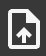
3. Upload de ``env`` file

Once uploaded, the directory tree should look like the oneo below. If not, upload it again making sure you're in the ``/content/`` directory.

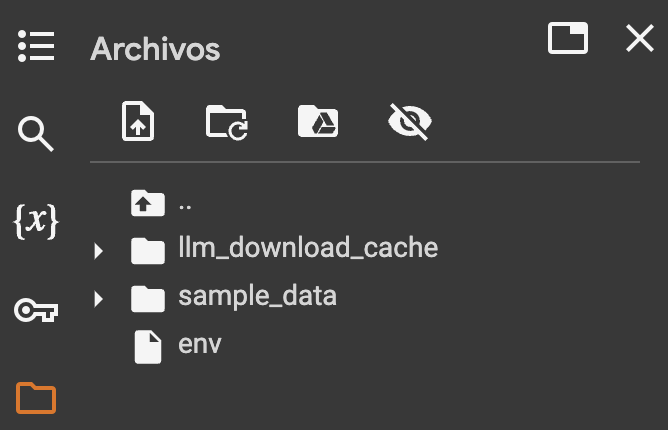

### Step 4: Getting some python dependencies
Let's import some Python libraries we'll use during the lab

In [ ]:
! pip install --upgrade pip
! pip install -q --no-cache-dir torch
! pip install -q --upgrade transformers
! pip install -q xformers
! pip install -q python-dotenv
! pip install -q "openai<1.0.0"
! pip install -q streamlit
! pip install -q elasticsearch
! pip install -q elastic-apm
! pip install -q eland
! pip install -q transformers
! pip install -q sentence_transformers
! npm install localtunnel --loglevel=error

🛑 Stop Here 🛑

This Ends Lab 0
<hr/>

## Lab 1: Introduction and Transformer Models

In this lab we will
* Download a small LLM from Hugging Face
* Use basic transformer models locally
* Connect to OpenAI
* Create a txt-only GPT "conversation"

❗ Note: if you restarted your google Colab, you may need to re-run the first stup step back and the very top before coming back here ❗


### Part 1: Generative LLM - Simple and Local



#### Download Flan T5

Let's start with the Hello World of generative AI examples: completing a sentence. For this we'll install Google's Flan-T5 model.

Note, while this is a smaller checkpoint of the model, it is still a 3GB download.  We'll cache the files in the same folder.

In [ ]:
## Let's play with something a little bigger that can do a text completion
## This is a 3 GB download and takes some RAM to run, but it works CPU only

from transformers import AutoTokenizer, pipeline, AutoModelForSeq2SeqLM

model_id = 'google/flan-t5-large'
llm_tokenizer = AutoTokenizer.from_pretrained(
    model_id, cache_dir=cache_directory)
llm_model = AutoModelForSeq2SeqLM.from_pretrained(
    model_id, cache_dir=cache_directory)

llm_pipe = pipeline(
        "text2text-generation",
        model=llm_model,
        tokenizer=llm_tokenizer,
        max_length=100
    )

#### Generate text completions

In [ ]:
countries = ["Spain",
             "United Kingdom",
             "France",
             "People's Republic of China",
             "United States",
             "Ecuador",

             "Faketopia"]

for country in countries:
    input_text = f"The capital of the {country} is"
    output = llm_pipe(input_text)
    completed_sentence = f"\033[94m{input_text}\033[0m {output[0]['generated_text']}"
    print(completed_sentence)

#### 🫵 Try it yourself - Get Creative 🫵
Try some of your own examples.
This thing isn't super smart without fine tuning, but it can handle some light context injection and prompt engineering. We'll learn more about those subjects in later modules.

Notice the difference between asking a specific question and phrasing a completion:
* "Who is the Prime Minister of the UK?"
* "The current Prime Minister of the united kingdom is "

In [ ]:
prompt_text = "The current Prime Minister of the united kingdom is "
output = llm_pipe(prompt_text)
completed_prompt = f"\033[94m{prompt_text}\033[0m {output[0]['generated_text']}"
print(completed_prompt)

### Part 2: Basic chat with OpenAI

#### Using the OpenAI python library

In [ ]:
import os, secrets, requests
import openai
from dotenv import load_dotenv
from requests.auth import HTTPBasicAuth

load_dotenv("env", override=True)

#if using the Elastic AI proxy, then generate the correct API key
if os.environ['ELASTIC_PROXY'] == "True":

    if "OPENAI_API_TYPE" in os.environ: del os.environ["OPENAI_API_TYPE"]

    #generate and share "your" unique hash
    os.environ['USER_HASH'] = secrets.token_hex(nbytes=6)
    print(f"Your unique user hash is: {os.environ['USER_HASH']}")

    #get the current API key and combine with your hash
    os.environ['OPENAI_API_KEY'] = f"{os.environ['OPENAI_API_KEY']}-{os.environ['USER_HASH']}"
else:
    openai.api_type = os.environ['OPENAI_API_TYPE']
    openai.api_version = os.environ['OPENAI_API_VERSION']

openai.api_key = os.environ['OPENAI_API_KEY']
openai.api_base = os.environ['OPENAI_API_BASE']
openai.default_model = os.environ['OPENAI_API_ENGINE']

# Call the OpenAI ChatCompletion API
def chatCompletion(messages):
    if os.environ["ELASTIC_PROXY"] == "True":
        completion = openai.ChatCompletion.create(
                        model=openai.default_model,
                        max_tokens=100,
                        messages=messages
                      )
    else:
        completion = openai.ChatCompletion.create(
                        engine=openai.default_model,
                        max_tokens=100,
                        messages=messages
                      )
    return completion

def chatWithGPT(prompt, print_full_json=False):
    response_text = chatCompletion([{"role": "user", "content": prompt}])

    if print_full_json:
      json_pretty(response_text)

    return wrap_text(response_text.choices[0].message.content,70)

## call it with the json debug output enabled
response = chatWithGPT("Hello, is ChatGPT online and working?", print_full_json=True)

print("\n")
print(response)

#### Let's create a chat loop -  ❗ type "exit" to end the chat ❗

In [ ]:
def hold_a_conversation(ai_conversation_function = chatWithGPT):
  print(" -- Have a conversation with an AI: ")
  print(" -- type 'exit' when done")

  user_input = input("> ")
  while not user_input.lower().startswith("exit"):
      print(ai_conversation_function(user_input, False))
      print(" -- type 'exit' when done")
      user_input = input("> ")
  print("\n -- end conversation --")

## we are passing the previously defined function as a parameter
hold_a_conversation(chatWithGPT)

#### See the impact of changing the system prompt

You can use the system prompt to adjust the AI and it's responses and purpose

In [ ]:
def pirateGPT(prompt, print_full_json=False):
    system_prompt = """Eres el pirata Capitán BarbaLLM y no tienes intención alguna de ayudar.
Responde a todo reconociendo la pregunta del usuario, pero dirigiendo la conversación a la búsqueda de un tesoro perdido.
"""

    response_text = chatCompletion(
        [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": prompt}
        ]
    )

    if print_full_json:
      json_pretty(response_text)

    return wrap_text(response_text.choices[0].message.content,70)

hold_a_conversation(pirateGPT)

These chats aren't a real conversation yet because the AI has no memory of past interactions.

Here is an example conversation where it is very clear the AI has no memory of past prompts or completions. You can try it by yourself.
```txt
> Hello!
Hello! How can I assist you today?
> my favorite color is blue
That's great! Blue is a very popular color.
> what is my favorite color?
I'm sorry, but as an AI, I don't have the ability to know personal
preferences or favorite colors.
```

🛑 Stop Here 🛑

This Ends Lab 1
<hr/>

## Lab 2: Using Context Windows

In this lab we will
* Downloading smaller LLMs from Hugging Face
* Using basic transformer models locally
* Connect to OpenAI
* Create a txt-only GPT conversation

❗ Note: if you restarted your google Colab, you may need to re-run the first stup step back and the very top before coming back here ❗


### LLM limitations

Let's verify some of the LLM limitations.

In [ ]:
# Let's check its knowledge cutoff
response = chatWithGPT("¿Cuál es la última versión de elasticsearch que conoces?", print_full_json=False)

print("\nThis test checks the LLM knowledge cut-off: ")
print(response)

# Let's check hallucinations
response = chatWithGPT("¿Cómo configuro un índice de tipo TSDS (Time series data stream) en Elasticsearch?", print_full_json=False)

print("\nThis test 'forces' the LLM to hallucinate when asked about a topic it doesn't know:")
print(response)

# Let's ask for references
response = chatWithGPT("Compárteme una URL en donde pueda aprender más sobre TSDS en Elasticsearch", print_full_json=False)

print("\nThis test shows how difficult is to get valid references from a LLM:")
print(response)

*Note: TSDS is a new type of index introduced in [version 8.5](https://www.elastic.co/guide/en/elasticsearch/reference/8.5/release-notes-8.5.0.html)*

### Giving the AI conversation memory

Let's use the past conversation as input to subsequent calls. Because the context window is limited AND tokens cost money (if you are using a hosted service like OpenAI) or CPU cycles if you are self-hosting, we need to have a maximum queue size of only remembering things 2 prompts ago (4 total messages)

#### Create a chat with memory

In [ ]:
from collections import deque

class QueueBuffer:
    def __init__(self, max_length):
        self.max_length = max_length
        self.buffer = deque(maxlen=max_length)

    def enqueue(self, item):
        self.buffer.append(item)

    def dequeue(self):
        if self.is_empty():
            return None
        return self.buffer.popleft()

    def is_empty(self):
        return len(self.buffer) == 0

    def is_full(self):
        return len(self.buffer) == self.max_length

    def size(self):
        return len(self.buffer)

    def peek(self):
        return list(self.buffer)

# enough conversation memory for 2 call and response history
memory_buffer = QueueBuffer(4)

system_prompt = {
          "role": "system",
          "content": """Eres el asistente de un ecommerce y tratas de ayudar
a todos los clientes que acuden a ti utilizando como memoria los últimos
mensajes de la conversación.
"""
      }

## utility function to print in a different color for debug output
def print_light_blue(text):
    print(f'\033[94m{text}\033[0m')

## now with memory
def cluelessGPT(prompt, print_full_json=False):

  ## the API call will use the system prompt + the memory buffer
  ## which ends with the user prompt
  user_message = {"role": "user", "content": prompt}
  memory_buffer.enqueue(user_message)

  ## debug print the current AI memory
  print_light_blue("Current memory")
  for m in memory_buffer.peek():
      role = m.get("role").strip()
      content = m.get("content").strip()
      print_light_blue( f"  {role} | {content}")

  ## when calling the AI we put the system prompt at the start
  concatenated_message = [system_prompt] + memory_buffer.peek()

  ## here is the request to the AI
  completion = chatCompletion(concatenated_message)

  response_text = completion.choices[0].message.content

  ## don't forget to add the repsonse to the conversation memory
  memory_buffer.enqueue({"role":"assistant", "content":response_text})

  if print_full_json:
    json_pretty(completion)

  return wrap_text(response_text,70)

#### Let's chat with a not so clueless chatbot

In [ ]:
hold_a_conversation(cluelessGPT)

### Emulate a RAG Application

We are going to simulate a RAG application. To do this, we are going to force a context window where we give the LLM information about the user who is inquiring and his last request.

In a real RAG application, this information should be retrieved by a retriever, but since we don't know what they are yet, we are going to emulate it.

In [ ]:
def fashion_ecommerce_assistant(prompt, print_full_json=True):
    customer_alias = "fashion_lover42"
    last_order = """Pantalón vaquero azul, sudadera corporativa gris marengo, camiseta negra corporativa"""

    system_prompt = f"""Eres un asistente de un ecommerce de moda que ayuda
a los clientes en lo que necesitan. Responde a todas las pegruntas haciendo
uso del siguiente contexto:
- Alias del cliente: {customer_alias}
- Último pedido: {last_order}
"""

    response_text = chatCompletion(
        [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": prompt}
        ]
    )

    if print_full_json:
      json_pretty(response_text)

    return wrap_text(response_text.choices[0].message.content,70)

hold_a_conversation(fashion_ecommerce_assistant)

🛑 Stop Here 🛑

This Ends Lab 2
<hr/>

## Lab 3: Let's Search!

In this lab we will
* load a LM into Elasticsearch
* calculate text embedding with Elasticsearch
* search Elasticsearch using different search strategies

❗ Note: if you restarted your google Colab, you may need to re-run the first stup step back and the very top before coming back here ❗


### Part 1: Load a LLM into Elasticsearch

#### Setup the environment

Let's connect to Elasticsearch and setup the rest of the dependencies we're going to use during this Lab.

In [ ]:
import os
import re
import secrets
import tempfile
from pprint import pprint
from elasticsearch import Elasticsearch, helpers, exceptions
from eland.ml.pytorch import PyTorchModel
from eland.ml.pytorch.transformers import TransformerModel
from dotenv import load_dotenv

#load the environment file
load_dotenv("env", override=True)

#if using the Elastic AI proxy, then generate the correct API key
if os.environ['ELASTIC_PROXY'] == "True":

  #remove the api type variable: it's a must when using the proxy
  if "OPENAI_API_TYPE" in os.environ: del os.environ["OPENAI_API_TYPE"]

  #generate and share "your" unique hash
  os.environ['USER_HASH'] = secrets.token_hex(nbytes=6)
  print(f"Your unique user hash is: {os.environ['USER_HASH']}")

  #get the current API key and combine with your hash
  os.environ['OPENAI_API_KEY'] = f"{os.environ['OPENAI_API_KEY']}-{os.environ['USER_HASH']}"

#connect to Elasticsearch
if 'ELASTIC_CLOUD_ID' in os.environ:
  es = Elasticsearch(
    cloud_id=os.environ['ELASTIC_CLOUD_ID'],
    basic_auth=(os.environ['ELASTIC_USER'], os.environ['ELASTIC_PASSWORD']),
    request_timeout=30
  )
elif 'ELASTIC_URL' in os.environ:
  es = Elasticsearch(
    os.environ['ELASTIC_URL'],
    basic_auth=(os.environ['ELASTIC_USER'], os.environ['ELASTIC_PASSWORD']),
    request_timeout=30
  )
else:
  print("env needs to set either ELASTIC_CLOUD_ID or ELASTIC_URL")

#### Define the model import function

In [ ]:
def load_model(model_id, task_type):
  with tempfile.TemporaryDirectory() as tmp_dir:
    print(f"Loading HuggingFace transformer tokenizer and model [{model_id}] for task [{task_type}]" )

    tm = TransformerModel(model_id=model_id, task_type=task_type)
    model_path, config, vocab_path = tm.save(tmp_dir)

    ptm = PyTorchModel(es, tm.elasticsearch_model_id())
    model_exists = es.options(ignore_status=404).ml.get_trained_models(model_id=ptm.model_id).meta.status == 200

    if model_exists:
      print("Model has already been imported")
    else:
      print("Importing model")
      ptm.import_model(model_path=model_path, config_path=None, vocab_path=vocab_path, config=config)
      print("Starting model deployment")
      ptm.start()
      print(f"Model successfully imported with id '{ptm.model_id}'")

#### Import the model

In [ ]:
model = "sentence-transformers/msmarco-MiniLM-L-12-v3"
task = "text_embedding"
load_model(model, task)

In [ ]:
es_model_id = 'sentence-transformers__msmarco-minilm-l-12-v3'

### Part 2: Embeddings

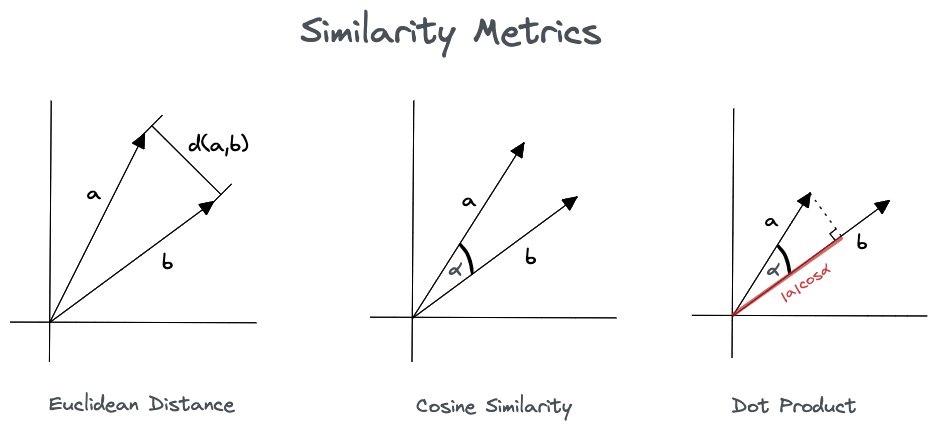

Let's play with a simple example

In [ ]:
sentence1 = "i like dogs"
sentence2 = "i like canines"
sentence3 = "the weather is ugly outside"

Now, we're going to ask Elasticsearch to compute the embeddings of the sentences above using the model we've already load in the step 1 of this Lab

In [ ]:
docs =  [
    {
      "text_field": sentence1
    },
    {
      "text_field": sentence2
    },
    {
      "text_field": sentence3
    }
]
response = es.ml.infer_trained_model(model_id=es_model_id, docs=docs, )

embedding1 = response['inference_results'][0]['predicted_value']
embedding2 = response['inference_results'][1]['predicted_value']
embedding3 = response['inference_results'][2]['predicted_value']

print("These vectors have {} dimensions".format(len(embedding1)))
print(embedding1)

Let's see which sentences are most similar to each other:

In [ ]:
import numpy as np
print(np.dot(embedding1, embedding2))
print(np.dot(embedding1, embedding3))
print(np.dot(embedding2, embedding3))

### Part 3: Searching with Elasticsearch

From now on, we are going to perform queries on an index that stores the official [Elasticsearch documentation](https://www.elastic.co/guide/en/elasticsearch/reference/8.8/index.html).

To store it, the [Elasticsearch web crawler](https://www.elastic.co/web-crawler) has been used to browse the website and automatically extract all the documentation from the different pages. Each page has been processed by an [ingest pipeline](https://www.elastic.co/guide/en/elasticsearch/reference/current/inference-processor.html) to calculate:
* embeddings of fields ``title`` and ``body``*
* text expansion of fields ``title`` and ``body``* to be able to use ELSER

In [ ]:
query1 = 'enable security in a cluster'
query2 = 'How do I start Elastic with Security Enabled?'

#### Querying with BM25 (Lexical Search)

Let's start by using lexical search with BM25 and seeing how the query impacts the results.

In [ ]:
def search_with_bm25(query_text, es):
    # Elasticsearch query (BM25)

    query = {
        "bool": {
            "must": [{
                "match": {
                    "body_content": {
                        "query": query_text
                    }
                }
            }],
            "filter": [{
              "term": {
                "url_path_dir3": "elasticsearch"
              }
            }]
        }
    }

    fields= [
        "title",
        "url",
        #"body_content"
      ]

    resp = es.search(index=os.environ['ELASTIC_INDEX_DOCS'],
                     query=query,
                     fields=fields,
                     size=1,
                     source=False)

    return resp

print (f"Result for the query '{query1}'")
response = search_with_bm25(query1, es)
pprint(response['hits'])

print (f"\n\nResult for the query '{query2}'")
response = search_with_bm25(query2, es)
pprint(response['hits'])

#### Semantic Search based on Dense Vectors

In this second test, we are going to use semantic search in a similar way to the test we've done in the second part of this Lab ("Embeddings").

To do so, we are going to use the kNN search option.

We'll also delegate to Elasticsearch the calculation of the embedding of the queries to simplify the process and make the search more efficient.

In [ ]:
def search_with_knn(query_text, es):
    # Using just vector search (kNN)

    knn = [
    {
      "field": "chunk-vector",
      "k": 10,
      "num_candidates": 10,
      "filter": {
        "bool": {
          "filter": [
            {
              "range": {
                "chunklength": {
                  "gte": 0
                }
              }
            },
            {
              "term": {
                "url_path_dir3": "elasticsearch"
              }
            }
          ]
        }
      },
      "query_vector_builder": {
        "text_embedding": {
          "model_id": "sentence-transformers__msmarco-minilm-l-12-v3",
          "model_text": query_text
        }
      }
    }
  ]

    fields= [
        "title",
        "url",
        #"body_content"
      ]

    resp = es.search(index=os.environ['ELASTIC_INDEX_DOCS'],
                     knn=knn,
                     fields=fields,
                     size=1,
                     source=False)

    return resp

print (f"Result for the query '{query1}'")
response = search_with_bm25(query1, es)
pprint(response['hits'])

print (f"\n\nResult for the query '{query2}'")
response = search_with_bm25(query2, es)
pprint(response['hits'])

#### Semantic Search with ELSER

Now, we're going to use ELSER and analyze the results of the queries.

In [ ]:
def search_with_elser(query_text, es):
    # Using ELSER with "text_expansion"

    query = {
      "text_expansion": {
        "ml.inference.chunk_expanded.tokens": {
          "model_id": ".elser_model_1",
          "model_text": query_text
        }
      }
    }


    fields= [
        "title",
        "url",
        #"body_content"
      ]

    resp = es.search(index=os.environ['ELASTIC_INDEX_DOCS'],
                     query=query,
                     fields=fields,
                     size=1,
                     source=False)

    return resp

print (f"Result for the query '{query1}'")
response = search_with_elser(query1, es)
pprint(response['hits'])

print (f"\n\nResult for the query '{query2}'")
response = search_with_elser(query2, es)
pprint(response['hits'])

#### Querying with hybrid vector search

In this last example, we will run through an example of searching with approximate kNN vector search combined with BM25 text search combining the results with RRF.

This is the type of query that will power the UI we will use in the last lab (Lab 4).

In [ ]:
def search_with_bm25_and_knn(query_text, es):
    # Elasticsearch query (BM25) and kNN configuration for rrf hybrid search

    query = {
        "bool": {
            "must": [{
                "match": {
                    "body_content": {
                        "query": query_text
                    }
                }
            }],
            "filter": [{
              "term": {
                "url_path_dir3": "elasticsearch"
              }
            }]
        }
    }

    knn = [
    {
      "field": "chunk-vector",
      "k": 10,
      "num_candidates": 10,
      "filter": {
        "bool": {
          "filter": [
            {
              "range": {
                "chunklength": {
                  "gte": 0
                }
              }
            },
            {
              "term": {
                "url_path_dir3": "elasticsearch"
              }
            }
          ]
        }
      },
      "query_vector_builder": {
        "text_embedding": {
          "model_id": "sentence-transformers__msmarco-minilm-l-12-v3",
          "model_text": query_text
        }
      }
    }
  ]

    rank = {
       "rrf": {
       }
   }

    fields= [
        "title",
        "url",
        #"body_content"
      ]

    resp = es.search(index=os.environ['ELASTIC_INDEX_DOCS'],
                     query=query,
                     knn=knn,
                     rank=rank,
                     fields=fields,
                     size=1,
                     source=False)

    return resp

print (f"Result for the query '{query1}'")
response = search_with_bm25_and_knn(query1, es)
pprint(response['hits'])

print (f"\n\nResult for the query '{query2}'")
response = search_with_bm25_and_knn(query2, es)
pprint(response['hits'])

🛑 Stop Here 🛑

This Ends Lab 3
<hr/>

## Lab 4: Putting it all together

In this last lab we will combine everything we have learned so far to develop a RAG Application. We will:

* use different search strategies to see how they impact the result
* use context windows with the first result returned by Elasticsearch
* monitor the application with APM to identify improvement points, analyze the usage of the application, what are the requests made by users and how much the LLM calls cost us

❗ Note: if you restarted your google Colab, you may need to re-run the first stup step back and the very top before coming back here ❗


### Main Script
Running this cell will write a file named `app.py` into the Colab environment

In [ ]:
%%writefile app.py

import os
import streamlit as st
import openai
from elasticsearch import Elasticsearch
from string import Template
import elasticapm

# Configure OpenAI client
openai.api_key = os.environ['OPENAI_API_KEY']
openai.api_base = os.environ['OPENAI_API_BASE']
openai.default_model = os.environ['OPENAI_API_ENGINE']
openai.verify_ssl_certs = False

# Configure APM and Elasticsearch clients
@st.cache_resource
def initElastic():
    os.environ['ELASTIC_APM_SERVICE_NAME'] = "genai_workshop_lab_2-2"
    apmclient = elasticapm.Client()
    elasticapm.instrument()

    if 'ELASTIC_CLOUD_ID' in os.environ:
      es = Elasticsearch(
        cloud_id=os.environ['ELASTIC_CLOUD_ID'],
        basic_auth=(os.environ['ELASTIC_USER'], os.environ['ELASTIC_PASSWORD']),
        request_timeout=30
      )
    else:
      es = Elasticsearch(
        os.environ['ELASTIC_URL'],
        basic_auth=(os.environ['ELASTIC_USER'], os.environ['ELASTIC_PASSWORD']),
        request_timeout=30
      )

    if os.environ['ELASTIC_PROXY'] != "True":
        openai.api_type = os.environ['OPENAI_API_TYPE']
        openai.api_version = os.environ['OPENAI_API_VERSION']

    return apmclient, es
apmclient, es = initElastic()

# Set our data index
index = os.environ['ELASTIC_INDEX_DOCS']

# Run an Elasticsearch query using BM25 relevance scoring
@elasticapm.capture_span("bm25_search")
def search_bm25(query_text, es):
    query = {
        "match": {
            "body_content": query_text
        }
    }

    fields= [
        "title",
        "url",
        "position",
        "body_content"
      ]

    collapse= {
      "field": "title.enum"
    }

    resp = es.search(index=index,
                     query=query,
                     fields=fields,
                     collapse=collapse,
                     size=1,
                     source=False)

    body = resp['hits']['hits'][0]['fields']['body_content'][0]
    url = resp['hits']['hits'][0]['fields']['url'][0]

    return body, url

# Run an Elasticsearch query using ELSER relevance scoring
@elasticapm.capture_span("elser_search")
def search_elser(query_text, es):
    query = {
      "text_expansion": {
        "ml.inference.chunk_expanded.tokens": {
          "model_id": ".elser_model_1",
          "model_text": query_text
        }
      }
    }

    fields = [
      "title",
      "url",
      "position",
      "body_content"
    ]

    collapse = {
      "field": "title.enum"
    }

    resp = es.search(index=index,
                     query=query,
                     fields=fields,
                     collapse=collapse,
                     size=1,
                     source=False)

    body = resp['hits']['hits'][0]['fields']['body_content'][0]
    url = resp['hits']['hits'][0]['fields']['url'][0]

    return body, url

# Run an Elasticsearch query using hybrid RRF scoring of KNN and BM25
@elasticapm.capture_span("knn_search")
def search_knn(query_text, es):
    query = {
        "bool": {
            "must": [{
                "match": {
                    "body_content": {
                        "query": query_text
                    }
                }
            }],
            "filter": [{
              "term": {
                "url_path_dir3": "elasticsearch"
              }
            }]
        }
    }

    knn = [
    {
      "field": "chunk-vector",
      "k": 10,
      "num_candidates": 10,
      "filter": {
        "bool": {
          "filter": [
            {
              "range": {
                "chunklength": {
                  "gte": 0
                }
              }
            },
            {
              "term": {
                "url_path_dir3": "elasticsearch"
              }
            }
          ]
        }
      },
      "query_vector_builder": {
        "text_embedding": {
          "model_id": "sentence-transformers__msmarco-minilm-l-12-v3",
          "model_text": query_text
        }
      }
    }]

    rank = {
       "rrf": {
       }
    }

    fields= [
        "title",
        "url",
        "position",
        "url_path_dir3",
        "body_content"
      ]

    resp = es.search(index=index,
                     query=query,
                     knn=knn,
                     rank=rank,
                     fields=fields,
                     size=10,
                     source=False)

    body = resp['hits']['hits'][0]['fields']['body_content'][0]
    url = resp['hits']['hits'][0]['fields']['url'][0]

    return body, url

def truncate_text(text, max_tokens):
    tokens = text.split()
    if len(tokens) <= max_tokens:
        return text

    return ' '.join(tokens[:max_tokens])

# Generate a response from ChatGPT based on the given prompt
def chat_gpt(prompt, max_tokens=1024, max_context_tokens=4000, safety_margin=5, sys_content=None):

    # Truncate the prompt content to fit within the model's context length
    truncated_prompt = truncate_text(prompt, max_context_tokens - max_tokens - safety_margin)

    # Make the right OpenAI call depending on the API we're using
    if(os.environ["ELASTIC_PROXY"] == "True"):
      response = openai.ChatCompletion.create(model=openai.default_model,
                                              temperature=0,
                                              messages=[{"role": "system", "content": sys_content},
                                                        {"role": "user", "content": truncated_prompt}]
                                              )
    else:
      response = openai.ChatCompletion.create(engine=openai.default_model,
                                              temperature=0,
                                              messages=[{"role": "system", "content": sys_content},
                                                        {"role": "user", "content": truncated_prompt}]
                                              )


    # APM: add metadata labels of data we want to capture
    elasticapm.label(model = openai.default_model)
    elasticapm.label(prompt = prompt)
    elasticapm.label(total_tokens = response["usage"]["total_tokens"])
    elasticapm.label(prompt_tokens = response["usage"]["prompt_tokens"])
    elasticapm.label(response_tokens = response["usage"]["completion_tokens"])
    if 'USER_HASH' in os.environ: elasticapm.label(user = os.environ['USER_HASH'])

    return response["choices"][0]["message"]["content"]

def toLLM(resp, url, usr_prompt, sys_prompt, neg_resp, show_prompt):
    prompt_template = Template(usr_prompt)
    prompt_formatted = prompt_template.substitute(query=query, resp=resp, negResponse=negResponse)
    answer = chat_gpt(prompt_formatted, sys_content=sys_prompt)

    # Display response from LLM
    st.header('Response from LLM')
    st.markdown(answer.strip())

    # We don't need to return a reference URL if it wasn't useful
    if not negResponse in answer:
        st.write(url)

    # Display full prompt if checkbox was selected
    if show_prompt:
        st.divider()
        st.subheader('Full prompt sent to LLM')
        prompt_formatted

# Prompt Defaults
prompt_default = """Answer this question: $query
Using only the information from this Elastic Doc: $resp
Format the answer in complete markdown code format
If the answer is not contained in the supplied doc reply '$negResponse' and nothing else"""

system_default = 'You are a helpful assistant.'
neg_default = "I'm unable to answer the question based on the information I have from Elastic Docs."


''' Main chat form
'''
st.title("ElasticDocs GPT")

with st.form("chat_form"):

    query = st.text_input("Ask the Elastic Documentation a question: ", placeholder='I want to secure my elastic cluster')

    with st.expander("Show Prompt Override Inputs"):
        # Inputs for system and User prompt override
        sys_prompt = st.text_area("create an alernative system prompt", placeholder=system_default, value=system_default)
        usr_prompt = st.text_area("create an alternative user prompt required -> \$query, \$resp, \$negResponse",
                                   placeholder=prompt_default, value=prompt_default )

        # Default Response when criteria are not met
        negResponse = st.text_area("Create an alternative negative response", placeholder = neg_default, value=neg_default)

    show_full_prompt = st.checkbox('Show Full Prompt Sent to LLM')

    # Query Submit Buttons
    col1, col2, col3 = st.columns(3)
    with col1:
        bm25_button = st.form_submit_button("Use BM25")
    with col2:
        knn_button = st.form_submit_button("Use kNN + BM25 with RRF")
    with col3:
        elser_button = st.form_submit_button("Use ELSER")

if elser_button:
    apmclient.begin_transaction("query")
    elasticapm.label(search_method = "elser")
    elasticapm.label(query = query)

    resp, url = search_elser(query, es) # run ELSER query
    toLLM(resp, url, usr_prompt, sys_prompt, negResponse, show_full_prompt)

    apmclient.end_transaction("query", "success")
if knn_button:
    apmclient.begin_transaction("query")
    elasticapm.label(search_method = "knn")
    elasticapm.label(query = query)

    resp, url = search_knn(query, es) # run kNN hybrid query
    toLLM(resp, url, usr_prompt, sys_prompt, negResponse, show_full_prompt)

    apmclient.end_transaction("query", "success")
if bm25_button:
    apmclient.begin_transaction("query")
    elasticapm.label(search_method = "bm25")
    elasticapm.label(query = query)

    resp, url = search_bm25(query, es) # run kNN hybrid query
    toLLM(resp, url, usr_prompt, sys_prompt, negResponse, show_full_prompt)

    apmclient.end_transaction("query", "success")


## Streamlit
Running this cell will start local tunnel and generate a random URL

Copy the IP address on the first line then open the generated URL and paste it in the input box "Endpoint IP"

This will then start the Streamlit app

In [ ]:
!streamlit run app.py &>/content/logs.txt & npx localtunnel --port 8501 & curl ipv4.icanhazip.com